In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [2]:
# freqs, dark_s21 = np.load('./VNAsweep.npy')
freqs, dark_s21 = np.load('.\S21s_2025423_13h56\S21_dark.npy')
M_pxs = 32
N_pxs = 32

972


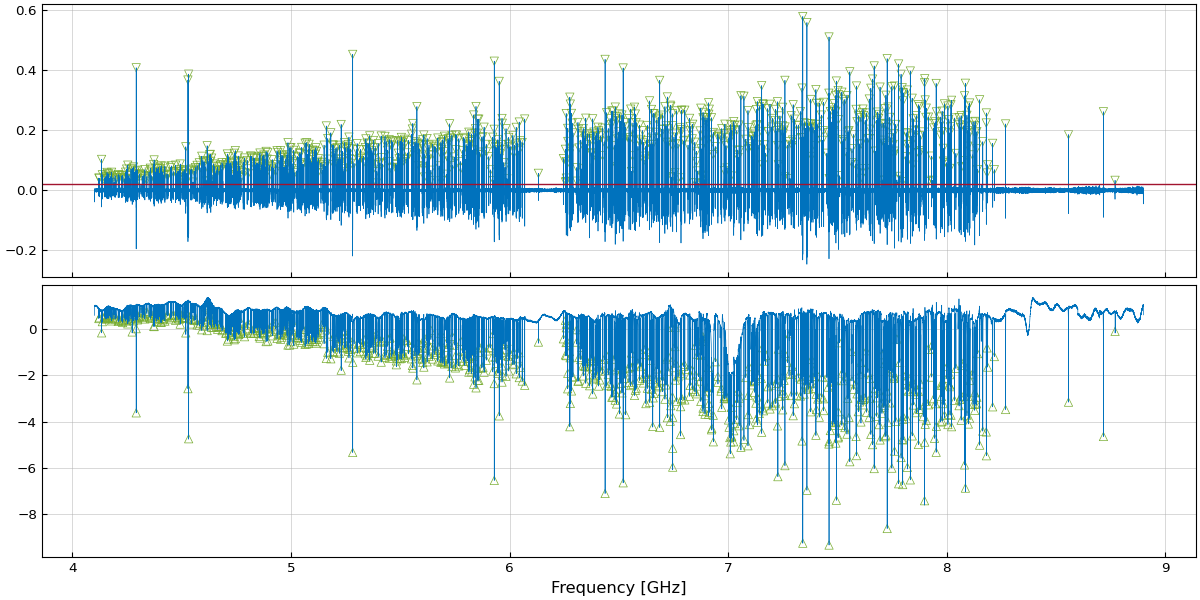

In [3]:
sw = 5 # even number
mph = 0.02
window = np.ones(sw)/sw
smooth_s21 = convolve(dark_s21, window, mode='same')
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = convolve(ds21, window, mode='same')
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']

locs += 1
f0s = freqs[locs]
s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
# ax['b'].plot(freqs, dark_s21, lw=.5, c='k')
ax['a'].plot(freqs[:-2], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[:-2][locs-1], heights, marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s, s21_mins, marker='^', c='None', edgecolor='g')
ax['b'].set_xlabel('Frequency [GHz]')
print(len(locs))

In [4]:
files = natsorted(glob('./S21s_2025423_13h56/*_*y0.npy'))
print(files)
nr_steps = len(files)
nr_kids = len(locs)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 = convolve(dark_s21, window, mode='same')
s0 = s21_mins
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = convolve(s21, window, mode='same')
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

['./S21s_2025423_13h56\\S21_x1y0.npy', './S21s_2025423_13h56\\S21_x2y0.npy', './S21s_2025423_13h56\\S21_x3y0.npy', './S21s_2025423_13h56\\S21_x4y0.npy', './S21s_2025423_13h56\\S21_x5y0.npy', './S21s_2025423_13h56\\S21_x6y0.npy', './S21s_2025423_13h56\\S21_x7y0.npy', './S21s_2025423_13h56\\S21_x8y0.npy', './S21s_2025423_13h56\\S21_x9y0.npy', './S21s_2025423_13h56\\S21_x10y0.npy', './S21s_2025423_13h56\\S21_x11y0.npy', './S21s_2025423_13h56\\S21_x12y0.npy', './S21s_2025423_13h56\\S21_x13y0.npy', './S21s_2025423_13h56\\S21_x14y0.npy', './S21s_2025423_13h56\\S21_x15y0.npy', './S21s_2025423_13h56\\S21_x16y0.npy', './S21s_2025423_13h56\\S21_x17y0.npy', './S21s_2025423_13h56\\S21_x18y0.npy', './S21s_2025423_13h56\\S21_x19y0.npy', './S21s_2025423_13h56\\S21_x20y0.npy', './S21s_2025423_13h56\\S21_x21y0.npy', './S21s_2025423_13h56\\S21_x22y0.npy', './S21s_2025423_13h56\\S21_x23y0.npy', './S21s_2025423_13h56\\S21_x24y0.npy', './S21s_2025423_13h56\\S21_x25y0.npy', './S21s_2025423_13h56\\S21_x26y0.

total:  972


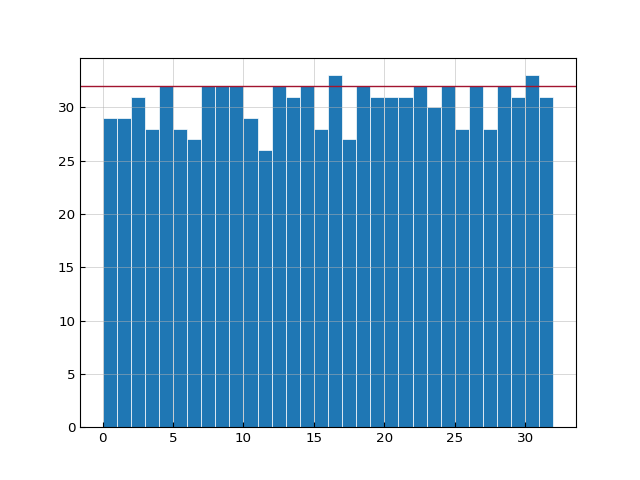

In [5]:
pos = np.empty((nr_kids,8)) # columns: meas idx, meas f0, x, y, design idx, design f0, design finger length, distance to centre
pos[:] = np.nan
pos[:, 0] = np.arange(nr_kids, dtype=int)
pos[:, 1] = f0s
for i in range(nr_kids):
    maximum = np.nanmax(s21s[:, i])
    second_maximum = np.sort(s21s[:, i])[-2]
    minimum = np.nanmin(s21s[:, i])
    mean = (np.sum(s21s[:, i]) - maximum - minimum)/(nr_steps-2)
    maxprominence = maximum - mean
    secprominence =  second_maximum - mean
    if maxprominence <.05:
        print('low SNR: ', int(pos[i, 0]))
    else: 
        pos[i, 3] = np.nanargmax(s21s[:, i])
    # if secprominence > .9:
        # print('overlapping peak? ', int(pos[i, 0]))
fig, ax = plt.subplots()
_ = ax.hist(pos[:, 3], bins=np.arange(nr_steps+1), facecolor='tab:blue', edgecolor='w')
ax.axhline(M_pxs, c='r')
print('total: ', np.sum(~np.isnan(pos[:, 3])))


In [6]:
# add_ids = [724, 694, 632, 564, 553, 441, 417, 407, 362, 322, 260] # should be sorted from high to low
# add_rows = [27,27,4,25,15,17,17,25,14,30,21]
# for i, id in enumerate(add_ids):
#     pos = np.insert(pos, id, pos[id], axis=0)
#     pos[id:, 0] += 1
#     pos[id, 3] = add_rows[i]
#     f0s = np.insert(f0s, id, f0s[id])
#     locs = np.insert(locs, id, locs[id])
#     s21s = np.insert(s21s, id, s21s[:, id], axis=1)

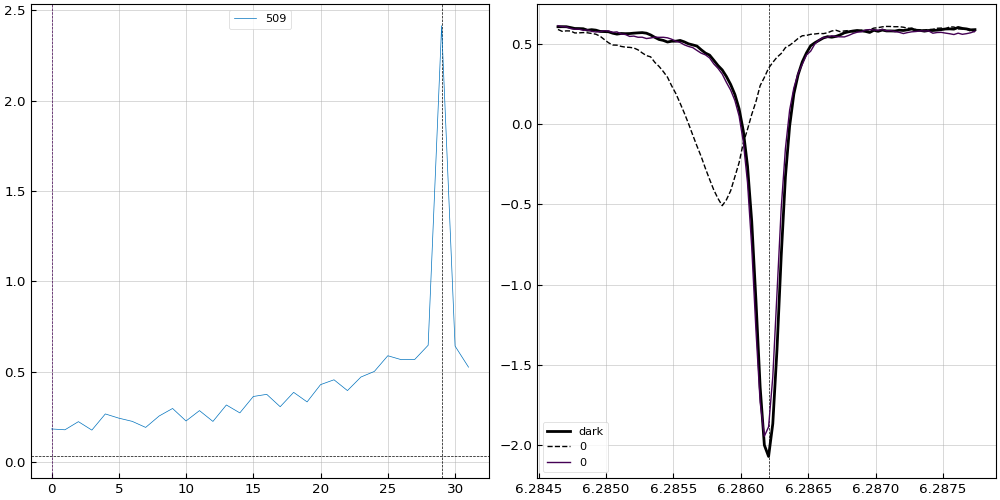

In [147]:
ids = [509]
fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
start = 0
stop = 20

steps = [0]
bw =  50
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))
for id in ids:
    max_step = np.nanargmax(s21s[:, id])
    res = f0s[id]
    loc = locs[id]
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=2, c='k', label='dark')
    ax['a'].axvline(res, c='k', ls='--', lw=.5)
    ax['b'].axhline(mean, ls='--', lw=.5, c='k')
    ax['b'].axvline(max_step, ls='--', lw=.5, c='k')
    ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[max_step, loc-bw:loc+bw], lw=1, label=str(step), c='k', ls='--')	
    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21s[:, id], lw=.5, label=str(id))
ax['b'].legend()
ax['a'].legend()

(25.0, 34.0)

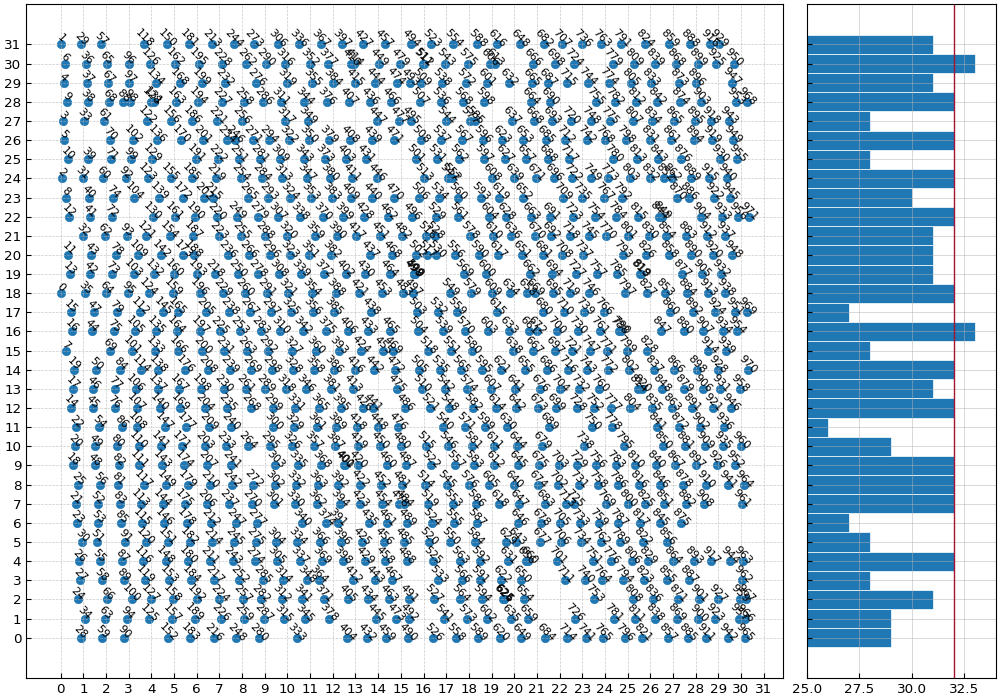

In [83]:
fig, ax = plt.subplot_mosaic('aaaab', figsize=(10,7), constrained_layout=True, sharey=True)   
ax['a'].scatter((pos[:, 0])/M_pxs, pos[:, 3], c='tab:blue')
for i, txt in enumerate(pos[:, 0]):
    ax['a'].annotate(int(txt), (pos[i, 0]/M_pxs, pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-45)
ax['a'].set_xticks(np.arange(0, M_pxs, 1))
ax['a'].set_yticks(np.arange(0, M_pxs, 1))
ax['a'].grid(True, which='both', linestyle='--', lw=.5)
ax['b'].hist(pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')
ax['b'].set_xlim([25,34])
# ax['a'].set_xlim([30,33])


(25.0, 34.0)

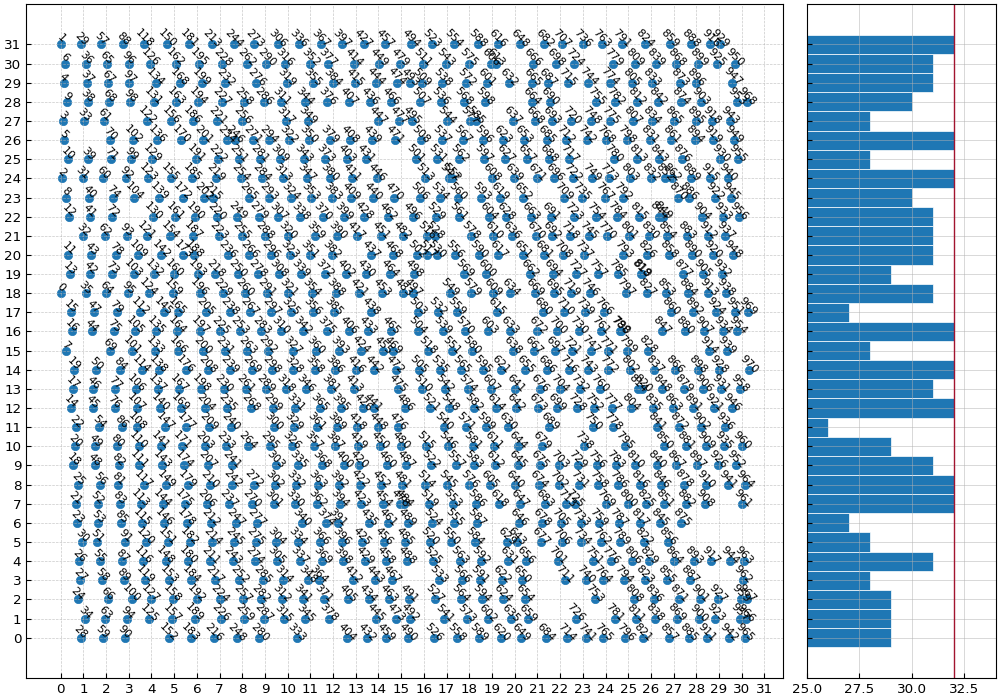

In [148]:
# remove 625, 626,660,661,401,658,500,499,971,410,512,
# 478=24
# 88= 31
# (499=6)
# (128 = ?)
del_mask = np.ones(nr_kids, dtype=bool)
del_mask[[625, 626, 660, 661, 401, 658, 500, 499, 971, 410, 512,128]] = False
filt_pos = pos[del_mask]
filt_pos[88, 3] = 31
fig, ax = plt.subplot_mosaic('aaaab', figsize=(10,7), constrained_layout=True, sharey=True)   
ax['a'].scatter((filt_pos[:, 0])/M_pxs, filt_pos[:, 3], c='tab:blue')
for i, txt in enumerate(filt_pos[:, 0]):
    ax['a'].annotate(int(txt), (filt_pos[i, 0]/M_pxs, filt_pos[i, 3]+.3), fontsize=8, ha='center', va='center', rotation=-45)
ax['a'].set_xticks(np.arange(0, M_pxs, 1))
ax['a'].set_yticks(np.arange(0, M_pxs, 1))
ax['a'].grid(True, which='both', linestyle='--', lw=.5)
ax['b'].hist(filt_pos[:, 3], bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')
ax['b'].set_xlim([25,34])

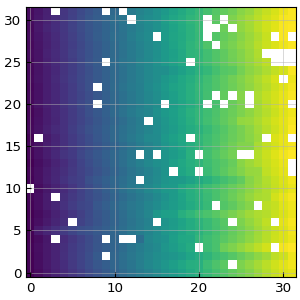

In [140]:


rows = [[] for _ in range(nr_steps)]
for i in filt_pos:
    if not np.isnan(i[3]):
        rows[int(i[3])].append(int(i[0]))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
nans = [[0,3],[0,9],[0,11],
        [1,12],[1,21],[1,23],
        [2,21],[2,22],[2,24],
        [3,15], [3,21],[3, 29],[3,31],
        [4,22],
        [5,28],[5,29],[5,30],[5,31],
        [6,9],[6,19],[6,29],[6,30],[6,31],
        [8,30],
        [9,8],
        [10,22],[10,24],[10,26],
        [11,8],[11,16],[11,21],[11,23],[11,26],[11,31],
        [13,14],
        [15,1],[15,19],[15,28],[15,31],
        [17,13],[17,15],[17,20],[17,25],[17,26],
        [18,31],
        [19,17],[19,20],[19,31],
        [20,13],
        [21,0],
        [22,3],
        [23,22],[23,27],
        [25,5],[25,15],[25,24],[25,29],
        [27,3],[27,9],[27,11],[27,12],
        [28,20],[28,29],
        [29,9],
        [30,24]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
kids_derolled = np.flip(kids_derolled, axis=0)
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')

[  1.  29.  57.  88. 118. 150. 181. 213. 244. 273. 306. 336. 367. 397.
 427. 457. 494. 523. 554. 588. 616. 648. 682. 707. 736. 763. 791. 824.
 859. 888. 916. 929.]


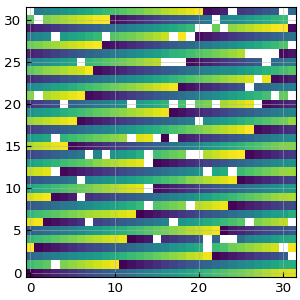

In [141]:
kids = copy(kids_derolled)
print(kids[0])
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*11)
# kids[0:2] = np.nan
# kids[-2:] = np.nan
# kids[:, -1] = np.nan
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')

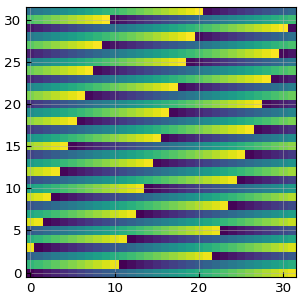

In [142]:
kid_id_board = np.load('../LT361w2chip9/kid_id_board_32x32.npy').astype(int)
master_array = np.load('../LT361w2chip9/LT361_chip8_master.npy')
master_array[0]
finger_lengths = master_array[:, 8]
design_f0s = master_array[:, 7]
coupler_lengths = master_array[:, 4]

fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')

In [143]:
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            master_array[idx, 9] = meas_f
master_array[0]
meas = master_array[:, 9]
design = master_array[:, 7]
nanmask = np.isnan(meas) | np.isnan(design)
nanmapmask = np.isnan(kids)

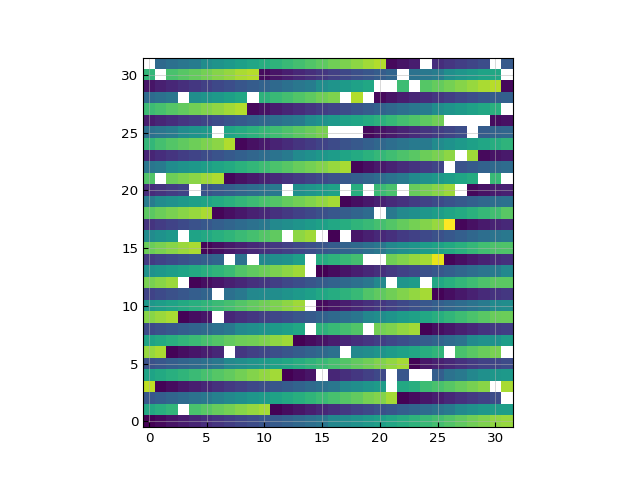

In [144]:
fig, ax = plt.subplots()
ax.imshow(meas[kid_id_board], origin='lower', cmap='viridis')

line
nan


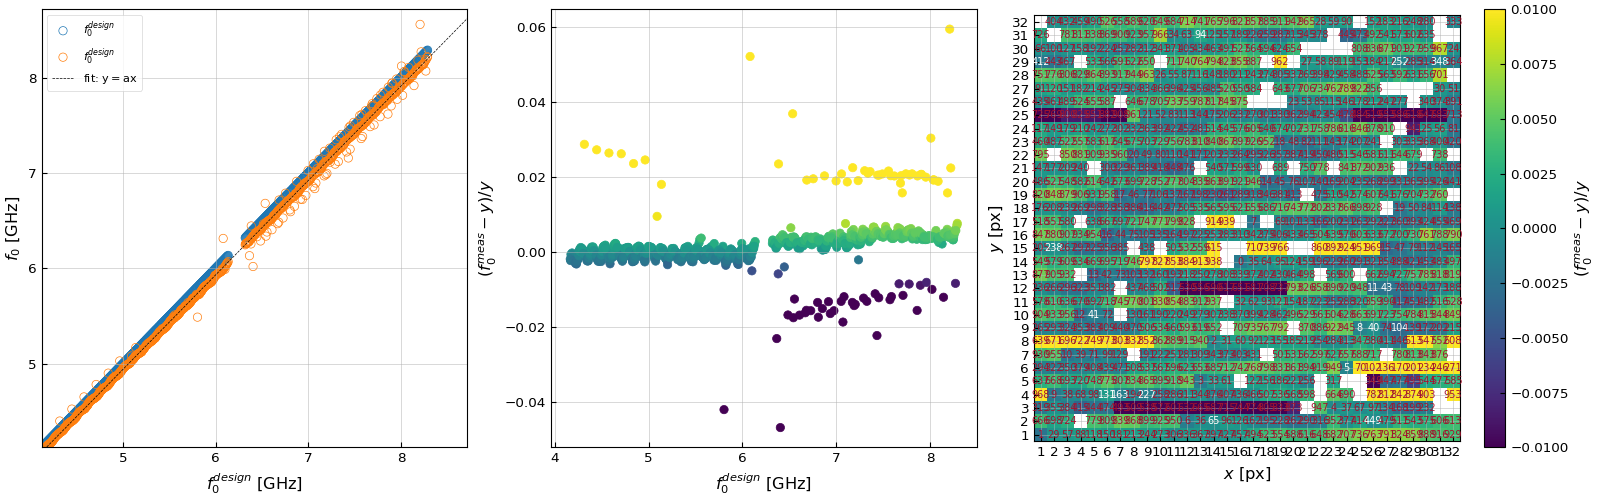

c:\Users\wilbertr\ownCloud2\PhD\PhD\PythonProjects\spatial-mapping\.venv\lib\site-packages\ipympl\backend_nbagg.py:279: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  self.manager.handle_json(content)


In [145]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x

line = linear
popt, pcov = curve_fit(line, design[~nanmask][:512], meas[~nanmask][:512])
design_fit = line(design, *popt)
df_f_fit = (meas - design_fit) / design_fit
df_f_map = df_f_fit[kid_id_board]
flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])

if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    print('line')
    popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
    fit = line(design, *popt)
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    fit = design
    label = 'f_0^{design}'
    save = 'nofit'
size=32

fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
clim = [-.01, .01]
ax['b'].scatter(design, df_f_fit, c=df_f_fit, vmin=clim[0], vmax=clim[1], label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if old_id == new_id:
                c = 'w'
            else:
                c = 'r'
            ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1))
ax['c'].set_yticks(np.arange(0, size, 1))
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(1, size+1, 1))
ax['c'].set_yticklabels(np.arange(1, size+1, 1))
# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
# cbar.ax.invert_yaxis()
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
# _ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
print(np.std(df_f_fit))
# fig, ax = plt.subplots()
# ax.scatter(pos[:, -1], df_f_corr[np.argsort(meas)])

0.0012669920249842191

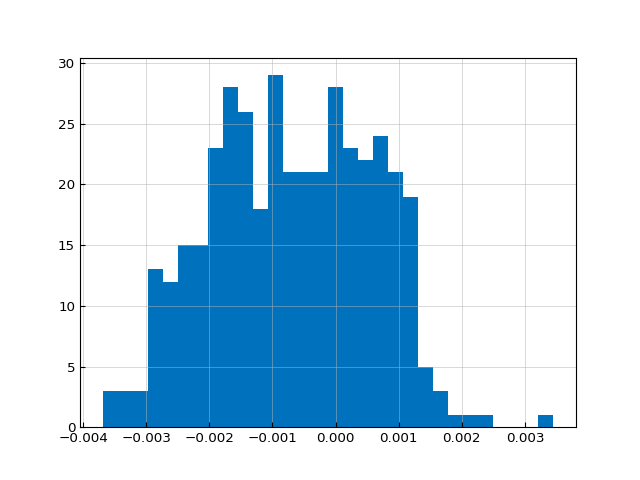

In [111]:
fig, ax = plt.subplots()
_ = ax.hist(df_f_fit[np.absolute(df_f_fit) < 0.004][:400], bins=30)
np.std(df_f_fit[np.absolute(df_f_fit) < 0.004][:400])

In [16]:
nr_scans = s21s.shape[0]

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan

    return maps

maps = map()

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
_ =ax.set_xticks(np.arange(0, size, 1))
_ =ax.set_yticks(np.arange(0, size, 1))
# Labels for major ticks
_ =ax.set_xticklabels(np.arange(1, size+1, 1))
_ =ax.set_yticklabels(np.arange(1, size+1, 1))

In [18]:
# import matplotlib.animation as animation

# fig, ax = plt.subplots(figsize=(8,8))
# cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
# for i, x in enumerate(df_fmap):
#     for j, y in enumerate(x):
#             if ~np.isnan(y):
#                 new_id = kids[i, j]
#                 ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
# ax.set_xticks(np.arange(0, size, 1))
# ax.set_yticks(np.arange(0, size, 1))
# # Labels for major ticks
# ax.set_xticklabels(np.arange(1, size+1, 1))
# ax.set_yticklabels(np.arange(1, size+1, 1))

# def update(frame):
#     cax.set_array(maps[:, :, frame])
#     return cax,
# ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
# plt.show()
# ani.save('animation_chip9.gif', writer='Pillow')


In [19]:
def rel_freqs(f0, oct, Q, nr_kids):
    Q_spacing = Q*(2**(oct/nr_kids)-1)
    powers = np.arange(nr_kids)
    f0s = f0 * (1+Q_spacing/Q)**powers
    return f0s

def rel_freqs(f0, fN, nr_kids):
    oct = np.log2(fN/f0)
    gamma = 2**(oct/nr_kids)
    powers = np.arange(nr_kids)
    f0s = f0 * gamma**powers
    return f0s

def lin_freqs(f0, fN, nr_kids):
    return np.linspace(f0, fN, nr_kids, endpoint=True)

def line(x, a, b):
    return a*x+b


In [20]:
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)

In [ ]:
fig, ax = plt.subplots()
sorted_fs = meas[~nanmask][sort_idx]
df = 0.03
nr_kids = len(sorted_fs)
nr_lower = 504
nr_upper = nr_kids - nr_lower
ax.plot(sorted_fs, label='measured (sorted)')
popt, pcov = curve_fit(line, np.arange(nr_lower), sorted_fs[:nr_lower])
ax.plot(line(np.arange(nr_lower), *popt), label='fit lower')  
a_l, b_l = popt[0], popt[1]
popt, pcov = curve_fit(line, np.arange(nr_lower, nr_kids), sorted_fs[nr_lower:])
ax.plot(np.arange(nr_lower,nr_kids), line(np.arange(nr_lower,nr_kids), *popt), label='fit upper')  
a_u, b_u = popt[0], popt[1]
a = (a_l+a_u)/2
nibble_lower = line(np.arange(nr_lower), a, b_l)
smaller = np.sum((nibble_lower - sorted_fs[:nr_lower]) <= 0)
while smaller > 0:
    b_l += df
    nibble_lower = line(np.arange(nr_lower), a, b_l)
    smaller = np.sum((nibble_lower - sorted_fs[:nr_lower]) <= 0)
nibble_upper = line(np.arange(nr_lower, nr_kids), a, b_u)
smaller = np.sum((nibble_upper - sorted_fs[nr_lower]) <= 0)
while smaller > 0:
    b_l += df
    nibble_upper = line(np.arange(nr_lower, nr_kids), a, b_l)
    smaller = np.sum((nibble_upper - sorted_fs[nr_lower:]) <= 0)
print(smaller)
ax.plot(np.arange(nr_lower), nibble_lower, label='nibble lower')
ax.plot(np.arange(nr_lower, nr_kids), nibble_upper, label='nibble upper')
ax.set_ylabel('frequency [GHz]')    
ax.set_xlabel('kids')    
ax.legend()
nibble_freqs = np.hstack((nibble_lower, nibble_upper))[inverse_sort_idx]
master_array[:, 6][~nanmask] = nibble_freqs

In [ ]:
fig, axes = plt.subplot_mosaic('abcde', figsize=(15,3), constrained_layout=True)
ax = axes['a']
fingers = master_array[:, 2]
sorted_fingers = master_array[:, 2][sort_idx]
ax.scatter(design, fingers, label='design f')
ax.scatter(meas, fingers, label='meas f')
ax.scatter(nibble_freqs[inverse_sort_idx], fingers[~nanmask], label='nibble f')
ax.set_ylabel('finger length [um]')
ax.set_xlabel('frequency [GHz]')

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, meas[~nanmask], fingers[~nanmask])
fit_fingers = poly(meas, *popt)   
ax.plot(meas, fit_fingers, c='k', lw=1)	
new_fingers = poly(nibble_freqs, *popt)
nibble_fingers = new_fingers+(fingers[~nanmask]-fit_fingers[~nanmask])
trims = copy(meas)
trims[~nanmask] = nibble_fingers - fingers[~nanmask]
ax.scatter(nibble_freqs, nibble_fingers, c='r', lw=1, label='nibble f+trim')
ax.legend()

ax = axes['b']
ax.plot(trims[~nanmask])
ax.set_ylabel('trim [um]')
ax.set_xlabel('kids')
print('minimum trim = %.2f um' % np.nanmax(trims))

ax = axes['c']
ax.scatter(design, design, label='original design')
ax.scatter(design, meas, label='measured')
ax.scatter(design[~nanmask], nibble_freqs, label='nibble design')
ax.set_ylabel('freqency [GHz]')
ax.set_xlabel('design frequency [GHz]')
ax.legend()
ax = axes['d']
# bin_edges = np.linspace(0,10,100)
df = (nibble_freqs[sort_idx][1:]-nibble_freqs[sort_idx][:-1])*1e3
ax.hist(df, bins=30, facecolor='g')
ax.set_ylabel('Counts')
ax.set_xlabel('Spacing df [GHz]')
ax = axes['e']
ax.imshow(trims[kid_id_board], origin='lower')

master_array[:, 7][~nanmask] = nibble_fingers

In [91]:
np.save('LT361_chip9_trims.npy', -trims[kid_id_board])


In [ ]:
N_fingers = 13 # number of IDC fingers
nr_fingers_cut = 7
finger_length = 111.# full length of the fingers

In [ ]:
nr_fingers = 7
finger_length = 111
max_cut = 104
original_fingers= master_array[:, 2]
nibbled_fingers = master_array[:, 7]
original_cut = nr_fingers*finger_length - original_fingers
nibbled_cut = nr_fingers*finger_length - nibbled_fingers
np.sum((original_cut // max_cut) != (nibbled_cut // max_cut))